In [1]:
import os, sys
import time
import numpy as np
import pandas as pd
import random
from scipy import stats as st
import itertools

import torch

from tqdm.notebook import trange
from tqdm import tqdm

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns

In [2]:
for p in ['../spotlight_ext']:
    module_path = os.path.abspath(os.path.join(p))
    if module_path not in sys.path:
        sys.path.append(module_path)

random_state = np.random.RandomState(2020)

In [3]:
# load functions from another notebook
%run helpers.ipynb

In [4]:
# implicit_model = load_model('implicit_factorization')
lstm_model = load_model(model_type='entire')
pooling_model = load_model('pooling')

In [5]:
class ComputeLoss:
    def __init__(self, target, original_input, top_k=10, weights=[1, 0, 0], total_CFs=1):
        self.target_item = target
        self.top_k = top_k
        self.original_items = original_input
        self.total_CFs = total_CFs
        (self.proximity_weight, self.diversity_weight, self.regularization_weight) = weights

    def _compute_yloss(self, target_score, kth_score):
        yloss = 0.0
        for i in range(self.total_CFs):
#             temp_loss = max(0, target_score/kth_score - 1.0)
            temp_loss = target_score / kth_score

            yloss += temp_loss
        return yloss / self.total_CFs

    def _compute_dist(self, x_hat, x1):
        """Compute weighted distance between two vectors."""
    #     return sum(abs(x_hat - x1))
#         diff = set(x1).difference(set(x_hat))
        diff = np.setdiff1d(x1, x_hat)
        return len(diff)

    def _compute_proximity_loss(self, cfs):
        proximity_loss = 0.0
        for i in range(self.total_CFs):
            proximity_loss += self._compute_dist(cfs, self.original_items)
        return proximity_loss / np.multiply(len(self.original_items), self.total_CFs)

    def _compute_diversity_loss(self):
        proximity_loss = 0.0
        return proximity_loss / self.total_CFs

    def _compute_regularization_loss(self, x):
        """Adds a linear equality constraints to the loss functions - to ensure all levels of a categorical variable sums to one"""
        regularization_loss = 0.0
        for i in range(self.total_CFs):
            pass
#             for v in self.encoded_categorical_feature_indexes:
#                 regularization_loss += torch.pow((torch.sum(self.cfs[i][v[0]:v[-1]+1]) - 1.0), 2)
#             regularization_loss += max(0, x - 1.0)

        return regularization_loss

    def compute_loss(self, cfs, preds, ranking, total_CFs=1):
        """Computes the overall loss"""

        yloss = self._compute_yloss(preds[self.target_item], preds[(ranking == self.top_k).nonzero()][0])
        proximity_loss = self._compute_proximity_loss(cfs) if self.proximity_weight > 0 else 0.0
        diversity_loss = self._compute_diversity_loss() if self.diversity_weight > 0 else 0.0
        regularization_loss = self._compute_regularization_loss(yloss) if self.regularization_weight > 0 else 0.0

        loss = yloss + (self.proximity_weight * proximity_loss) \
            - (self.diversity_weight * diversity_loss) \
            + (self.regularization_weight * regularization_loss)
        return loss

In [6]:
class BaseStrategy:
    def __init__(self, item, interactions, max_length):
        self.target_item = item
        self.original_interactions = interactions
        self.max_length = max_length
        self.visited_ = set()

    def next_comb(self, reverse=False):
        raise NotImplementedError

    def _get_pos(self, number):
        bits = []
        for i, c in enumerate(bin(number)[:1:-1], 1):
            if c == '0':
                bits.append(i)
        return bits

In [7]:
class RandomSelection(BaseStrategy):
    def __init__(self, item, interactions, max_sequence_length):
        super().__init__(item, interactions, max_sequence_length)

    def next_comb(self, reverse=False):
        number = random.sample(range(1, pow(2, self.max_length)), 1)[0]
        while number in self.visited_:
            number = random.sample(range(1, pow(2, self.max_length)), 1)[0]
#         number = np.random.choice(np.setdiff1d(range(1, pow(2, self.max_length)), self.visited_))
        self.visited_.add(number)
        bits = self._get_pos(number)
        seq = np.delete(self.original_interactions, bits)

        return seq

In [8]:
class MostSimilarSelection(BaseStrategy):
    def __init__(self, item, interactions, max_sequence_length):
        super().__init__(item, interactions, max_sequence_length)
        self._get_sim_ranking()
        self.visited_.add(0)
        self.reverse_checks = []
        self.is_materialized = False

    def next_comb(self, reverse=False):
        if reverse:
            self._materialize_list()
            selected_item_indices = self.reverse_checks.pop(0) if len(self.reverse_checks) else []
        else:
            self.visited_.add(max(self.visited_) + 1)
            selected_item_indices = np.where(np.isin(
                self.rk_items,
                list(set(self.rk_items).difference(set(self.visited_)))
            ))[0]
        seq = self.original_interactions[selected_item_indices] if len(selected_item_indices) else None
        return seq

    def _get_sim_ranking(self):
        ranked_items = st.rankdata(pooling_sims_matrix[self.target_item, self.original_interactions])
        self.rk_items = self.max_length - ranked_items + 1

    def _materialize_list(self):
        if not self.is_materialized:
            psize = len(self.visited_) - 1  # do not consider initial added zero value
            # do not take account none/all excluded interacted items
            prods = list(map(list, itertools.product([0, 1], repeat=psize)))[1:-1]
#             last_item_indices = np.where(np.isin(
#                 self.rk_items,
#                 list(set(self.rk_items).difference(set(self.visited_)))
#             ))

            lvisited_ = np.asarray(list(self.visited_))[1:]
            for p in prods:
                self.reverse_checks.append(np.where(np.isin(
                    self.rk_items,
                    list(set(self.rk_items).difference(lvisited_[np.nonzero(np.multiply(p, lvisited_))])))
                ))

            self.is_materialized = True

In [9]:
def get_backend_strategy(backend):
    if 'random' in backend:
        return RandomSelection
    elif 'most_sim' in backend:
        return MostSimilarSelection
    else: print('Unkown strategy')

In [11]:
def _find_cfs(dataset, model, target_item_pos, no_users=None, backend='random', budget=500,
              max_allowed_permutations=None, top_k=10, total_CFs=1):
    num_users = no_users or max(dataset.users_ids) + 1
    strategy_type = get_backend_strategy(backend)

    best_tot_loss_data = dict.fromkeys(target_item_pos)

    with tqdm(total=len(target_item_pos), desc='target position loop') as pbar:
        for pos in target_item_pos:
            best_tot_loss_data[pos] = []
            pbar.update(10)

            for user_id in trange(1, num_users, desc='users loop', leave=False):  # dataset.num_users):

                seq_size = len(dataset.sequences[dataset.user_ids == user_id])
                _total_loss = [None] * seq_size

                for j in range(seq_size):
                    if all(v > 0 for v in dataset.sequences[dataset.user_ids == user_id][j]):
                        items_interacted = dataset.sequences[dataset.user_ids == user_id][j]
                        predictions = -model.predict(items_interacted)
                        predictions[items_interacted] = StaticVars.FLOAT_MAX

                        target_item = predictions.argsort()[min(top_k, int(pos)) - 1]

                        _total_loss[j] = InteractionsInfo(user_id, target_item)

                        loss = ComputeLoss(target_item, items_interacted, top_k)
                        strategy = strategy_type(target_item, items_interacted, dataset.max_sequence_length)

                        counter = 1
                        for _ in range(budget):
                            perm = strategy.next_comb(reverse=_total_loss[j].solution_found)
                            if perm is None: break  # there is no need to continue searching

                            # predict next top-k items about to be selected
                            preds = model.predict(perm)
                            preds[perm] = -StaticVars.FLOAT_MAX

                            # normalize logits produced by model, i.e., the probability distribution before normalization, 
                            # by using softmax
#                             tensor = torch.from_numpy(preds).float()
# #                             tensor = F.softmax(tensor, dim=0)
#                             print('after', tensor, F.softmax(tensor, dim=-1), torch.max(tensor))

                            rk_data = st.rankdata(-preds, method='ordinal')
                            computed_loss = loss.compute_loss(perm, preds, rk_data)
#                             print('stats', user_id, computed_loss, len(perm), rk_data[target_item])

                            # keep info about the best solution found depending on an objective function
                            _total_loss[j].update_values(
                                preds, rk_data, perm, items_interacted, computed_loss, counter, top_k)

                            counter += 1

                best_tot_loss_data[pos].append(_total_loss)

    return best_tot_loss_data

In [12]:
from spotlight.cross_validation import random_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset

# get dataset
dataset = get_movielens_dataset(variant='1M')
train, test = random_train_test_split(dataset, random_state=random_state)

max_sequence_length = 20
train = train.to_sequence(max_sequence_length=max_sequence_length)
test = test.to_sequence(max_sequence_length=max_sequence_length)

In [13]:
pooling_sims_matrix = gpu_embeddings_to_cosine_similarity_matrix(
    pooling_model._net.item_embeddings(
        torch.arange(0, test.num_items, dtype=torch.int64)
    )).detach().numpy()

# jaccard_sims_matrix = compute_sim_matrix(test, 'jaccard')

## **Random** strategy

In [14]:
random_cfs = _find_cfs(test, pooling_model, [3, 5, 7], no_users=500, backend='random', budget=1000)

target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [05:16, 15.83s/it]              

target position loop: 30it [10:32, 20.57s/it]

target position loop: 30it [15:50, 31.68s/it]


In [16]:
from collections import Counter


cnt = dict.fromkeys(random_cfs.keys())
non_solvable_cases = dict.fromkeys(random_cfs.keys())
for key, values in random_cfs.items():
    total_data = []
    cnt[key] = []
    non_solvable_cases[key] = []

    for items in values:
        for rec in items:
            if rec is None: continue

            if not rec.solution_found or rec.pos < 10: 
                non_solvable_cases[key].append(rec.user_id)
                continue

            total_data.append(rec.cfs_dist)

    cnt[key] = Counter(total_data)

Text(0.5, 0.98, 'No of items to exclude from interacted list to have the recommendations change accordingly')

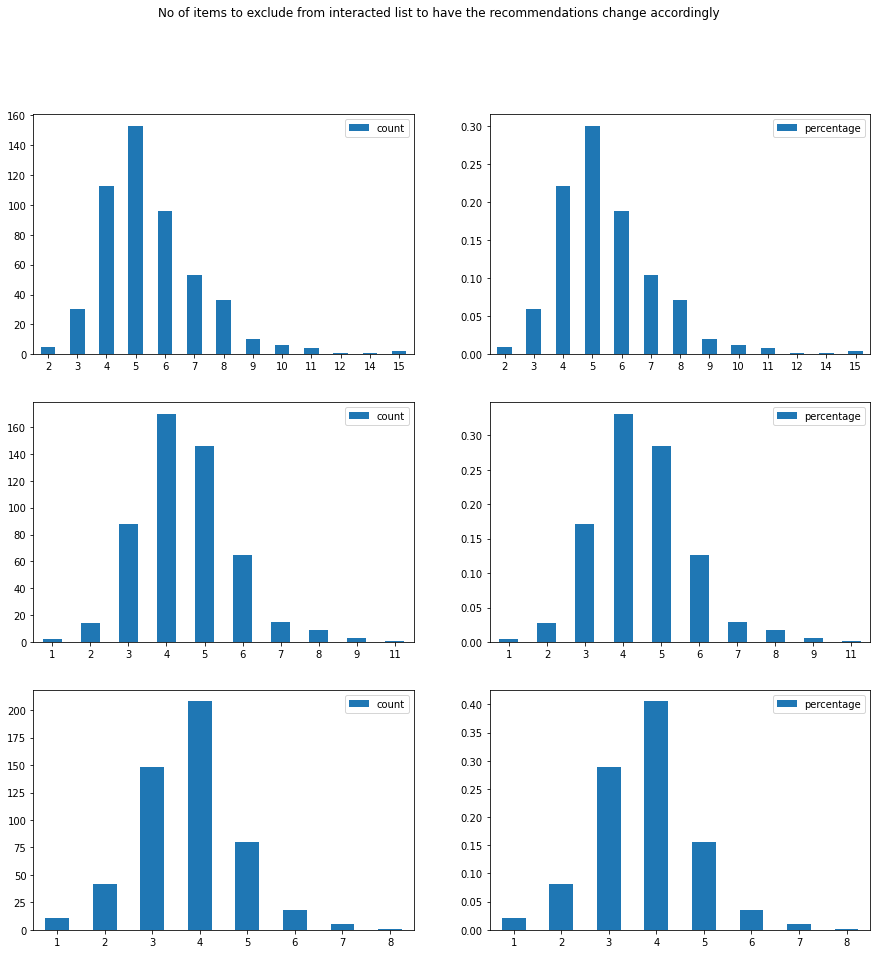

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

df = pd.DataFrame.from_dict(cnt[3], orient='index', columns=['count'])
df['percentage'] = df/df.sum()
df.sort_index().plot.bar(y='count', ax=axs[0, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[0, 1], rot=0)

df = pd.DataFrame.from_dict(cnt[5], orient='index', columns=['count'])
df['percentage'] = df/df.sum()
df.sort_index().plot.bar(y='count', ax=axs[1, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[1, 1], rot=0)

df = pd.DataFrame.from_dict(cnt[7], orient='index', columns=['count'])
df['percentage'] = df/df.sum()
df.sort_index().plot.bar(y='count', ax=axs[2, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[2, 1], rot=0)

plt.suptitle('No of items to exclude from interacted list to have the recommendations change accordingly')

In [18]:
from collections import Counter


cnt = dict.fromkeys(random_cfs.keys())
non_solvable_cases = dict.fromkeys(random_cfs.keys())
counter = dict.fromkeys(random_cfs.keys())
for key, values in random_cfs.items():
    cnt[key] = []
    non_solvable_cases[key] = []
    counter[key] = 0

    total_data = []
    for items in values:
        for rec in items:
            if rec is None: continue

            if not rec.solution_found or rec.pos < 10:
                non_solvable_cases[key].append(rec.user_id)
                total_data.append(rec.pos)

            counter[key] += 1

    cnt[key] = Counter(total_data)

Text(0.5, 0.98, 'Percentage of satisfied constraints')

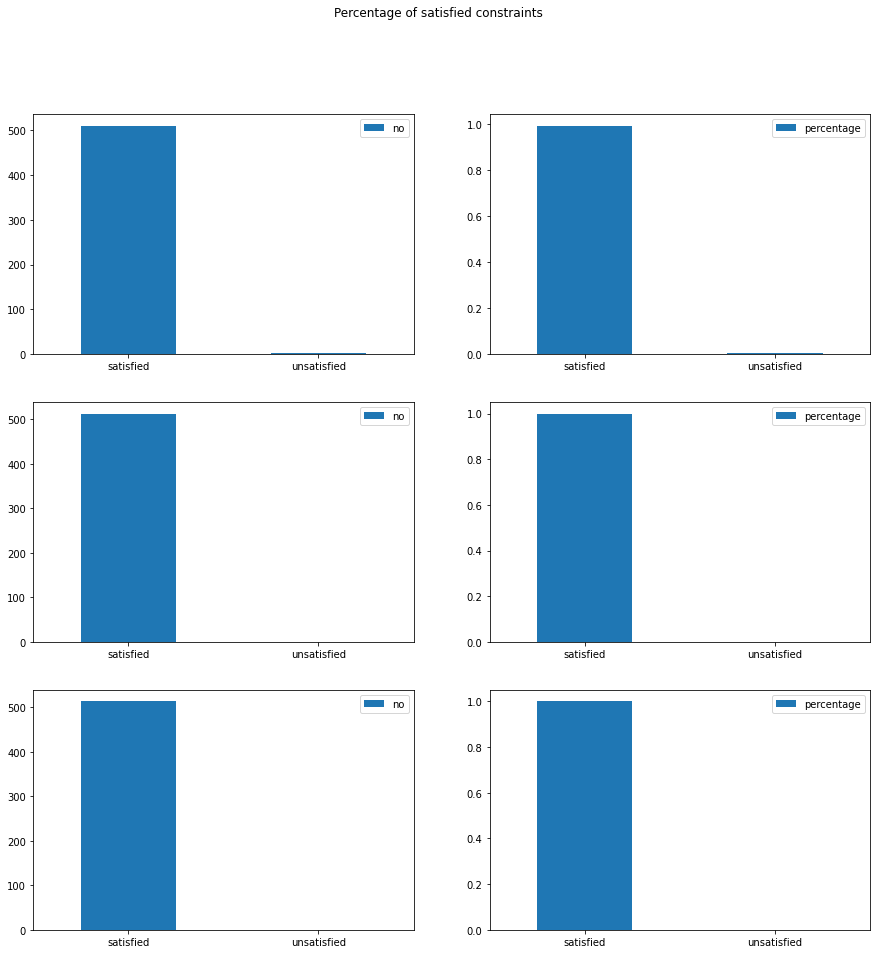

In [19]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))


df = pd.DataFrame([counter[3] - len(non_solvable_cases[3]), len(non_solvable_cases[3])], 
                  index=['satisfied', 'unsatisfied'], columns=['no'], dtype=np.float)
df['percentage'] = df / df.sum(axis=0)
df.sort_index().plot.bar(y='no', ax=axs[0, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[0, 1], rot=0)

df = pd.DataFrame([counter[5] - len(non_solvable_cases[5]), len(non_solvable_cases[5])], 
                  index=['satisfied', 'unsatisfied'], columns=['no'], dtype=np.float)
df['percentage'] = df / df.sum(axis=0)
df.sort_index().plot.bar(y='no', ax=axs[1, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[1, 1], rot=0)

df = pd.DataFrame([counter[7] - len(non_solvable_cases[7]), len(non_solvable_cases[7])], 
                  index=['satisfied', 'unsatisfied'], columns=['no'], dtype=np.float)
df['percentage'] = df / df.sum(axis=0)
df.sort_index().plot.bar(y='no', ax=axs[2, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[2, 1], rot=0)

plt.suptitle('Percentage of satisfied constraints')

Text(0.5, 0.98, 'Position of not achieved cases')

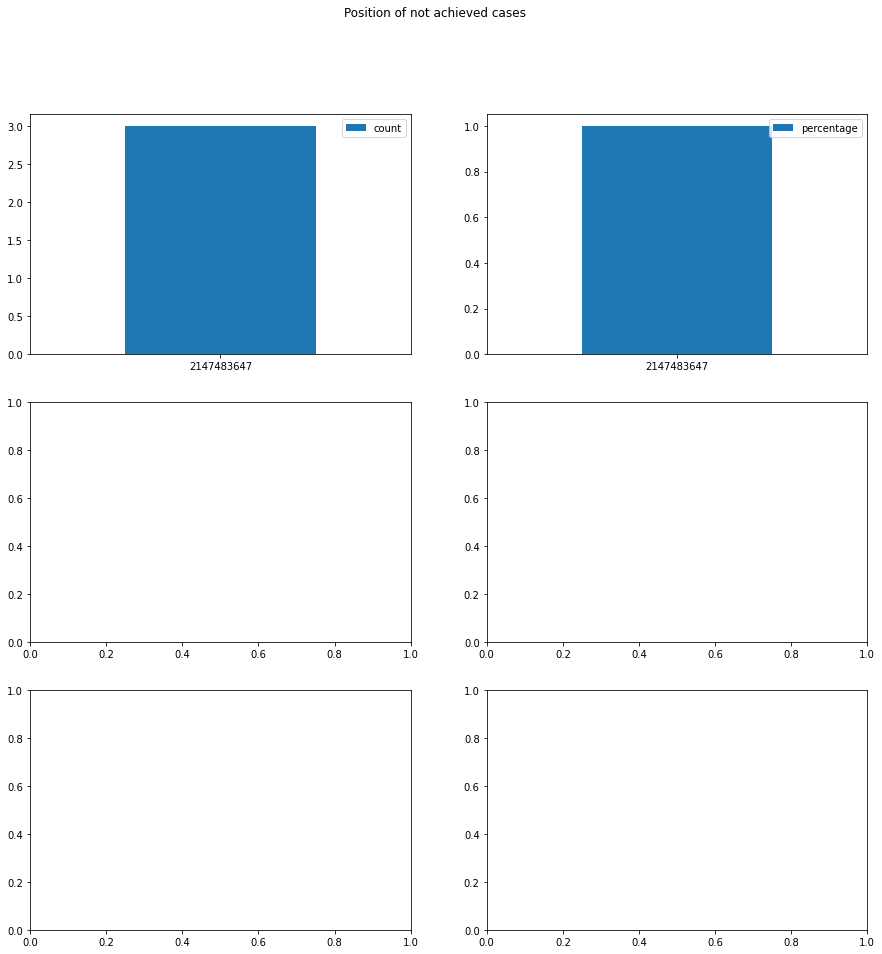

In [20]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

if cnt[3]:
    df = pd.DataFrame.from_dict(cnt[3], orient='index', columns=['count'])
    df['percentage'] = df / df.sum()
    df.sort_index().plot.bar(y='count', ax=axs[0, 0], rot=0)
    df.sort_index().plot.bar(y='percentage', ax=axs[0, 1], rot=0)

if cnt[5]:
    df = pd.DataFrame.from_dict(cnt[5], orient='index', columns=['count'])
    df['percentage'] = df / df.sum()
    df.sort_index().plot.bar(y='count', ax=axs[1, 0], rot=0)
    df.sort_index().plot.bar(y='percentage', ax=axs[1, 1], rot=0)

if cnt[7]:
    df = pd.DataFrame.from_dict(cnt[7], orient='index', columns=['count'])
    df['percentage'] = df / df.sum()
    df.sort_index().plot.bar(y='count', ax=axs[2, 0], rot=0)
    df.sort_index().plot.bar(y='percentage', ax=axs[2, 1], rot=0)

plt.suptitle('Position of not achieved cases')

## **Most Similar** strategy

In [21]:
most_sim_cfs = _find_cfs(test, pooling_model, [3, 5, 7], no_users=500, backend='most_sim', budget=1000)

target position loop:   0%|          | 0/3 [00:00<?, ?it/s]

target position loop: 20it [00:52,  2.63s/it]              

target position loop: 30it [01:07,  2.29s/it]

target position loop: 30it [01:14,  2.50s/it]


In [22]:
from collections import Counter


cnt = dict.fromkeys(most_sim_cfs.keys())
non_solvable_cases = dict.fromkeys(most_sim_cfs.keys())
for key, values in most_sim_cfs.items():
    total_data = []
    tot_data_2 = []
    cnt[key] = []
    non_solvable_cases[key] = []

    for items in values:
        for rec in items:
            if rec is None: continue

            if not rec.solution_found or rec.pos < 10:
                non_solvable_cases[key].append(rec.user_id)
                continue

            total_data.append(rec.cfs_dist)
            tot_data_2.append(len(rec.interactions['original']) - len(rec.interactions['initial']))

    cnt[key] = [Counter(tot_data_2), Counter(total_data)]

Text(0.5, 0.98, 'No of items to exclude from interacted list to have the recommendations change accordingly')

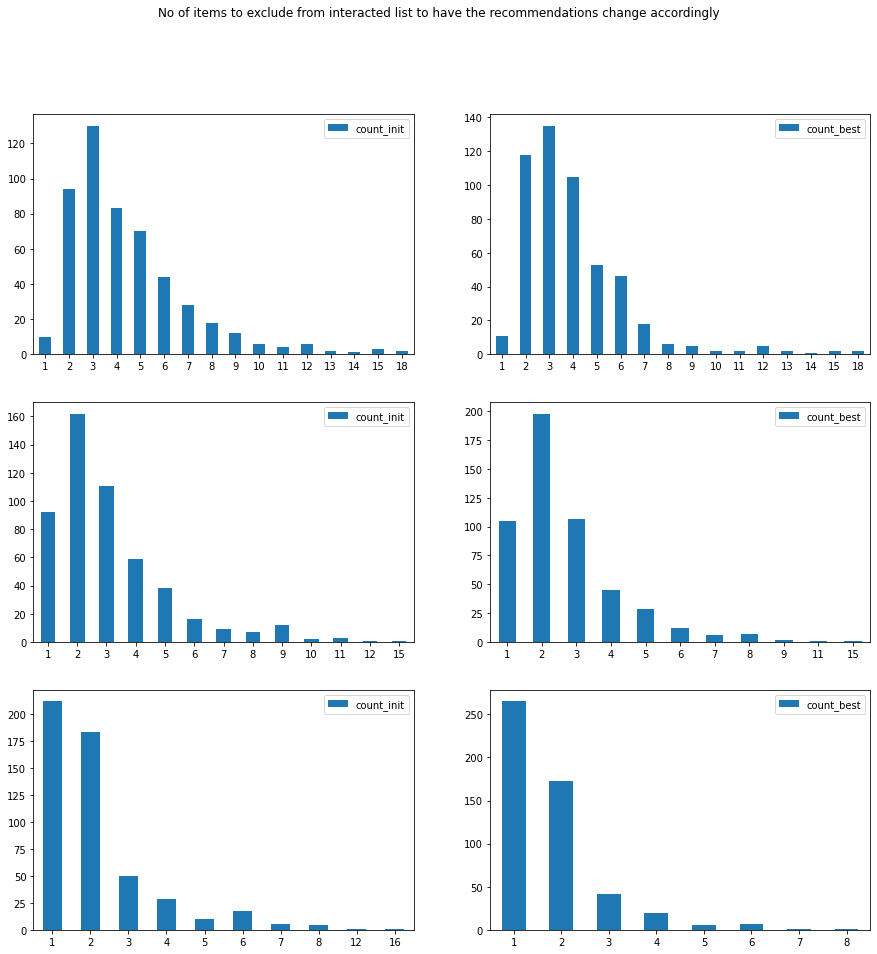

In [23]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

df = pd.DataFrame.from_dict(cnt[3][0], orient='index', columns=['count_init'])
df['percentage'] = df / df.sum()
df.sort_index().plot.bar(y='count_init', ax=axs[0, 0], rot=0)
# df.sort_index().plot.bar(y='percentage', ax=axs[0, 1], rot=0)
df = pd.DataFrame.from_dict(cnt[3][1], orient='index', columns=['count_best'])
df.sort_index().plot.bar(y='count_best', ax=axs[0, 1], rot=0)

df = pd.DataFrame.from_dict(cnt[5][0], orient='index', columns=['count_init'])
df['percentage'] = df / df.sum()
df.sort_index().plot.bar(y='count_init', ax=axs[1, 0], rot=0)
# df.sort_index().plot.bar(y='percentage', ax=axs[0, 1], rot=0)
df = pd.DataFrame.from_dict(cnt[5][1], orient='index', columns=['count_best'])
df.sort_index().plot.bar(y='count_best', ax=axs[1, 1], rot=0)

df = pd.DataFrame.from_dict(cnt[7][0], orient='index', columns=['count_init'])
df['percentage'] = df / df.sum()
df.sort_index().plot.bar(y='count_init', ax=axs[2, 0], rot=0)
# df.sort_index().plot.bar(y='percentage', ax=axs[0, 1], rot=0)
df = pd.DataFrame.from_dict(cnt[7][1], orient='index', columns=['count_best'])
df.sort_index().plot.bar(y='count_best', ax=axs[2, 1], rot=0)

plt.suptitle('No of items to exclude from interacted list to have the recommendations change accordingly')

In [63]:
from collections import Counter


cnt = dict.fromkeys(most_sim_cfs.keys())
non_solvable_cases = dict.fromkeys(most_sim_cfs.keys())
counter = dict.fromkeys(most_sim_cfs.keys())
for key, values in most_sim_cfs.items():
    cnt[key] = []
    non_solvable_cases[key] = []
    counter[key] = 0

    total_data = []
    for items in values:
        for rec in items:
            if rec is None: continue

            if not rec.solution_found or rec.pos < 10: 
                non_solvable_cases[key].append(rec.user_id)
                total_data.append(rec.pos)

            counter[key] += 1

    cnt[key] = Counter(total_data)

Text(0.5, 0.98, 'Percentage of satisfied constraints')

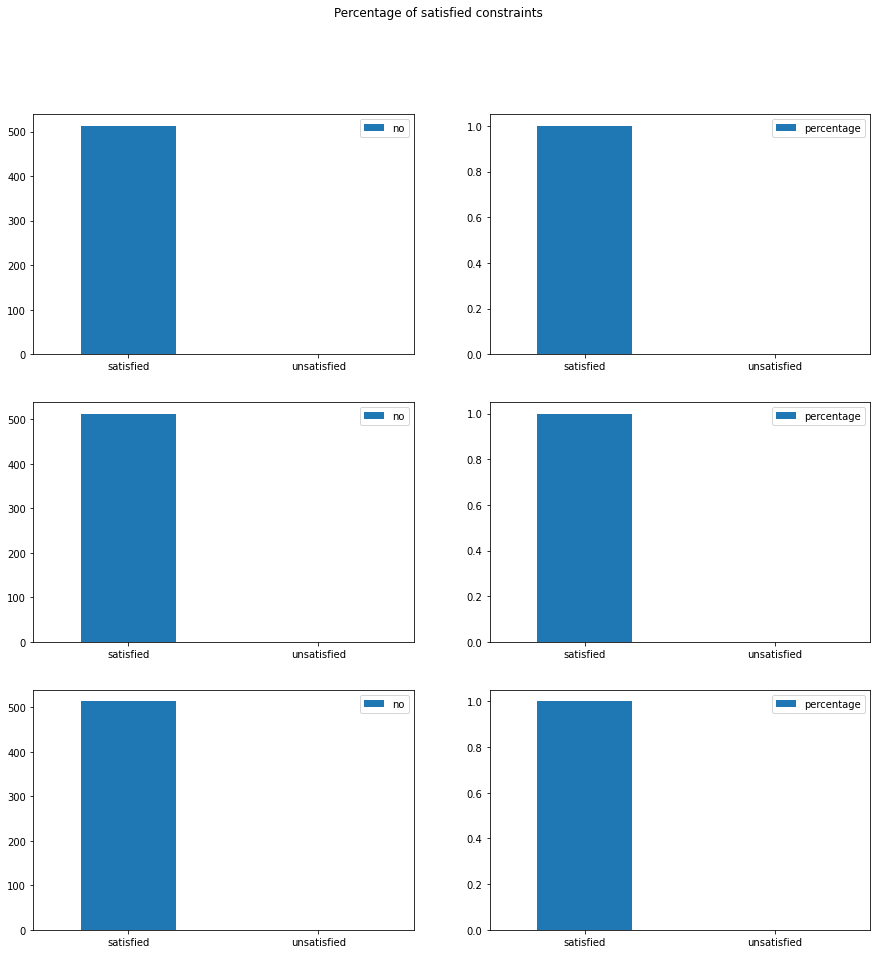

In [64]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))


df = pd.DataFrame([counter[3] - len(non_solvable_cases[3]), len(non_solvable_cases[3])],
                  index=['satisfied', 'unsatisfied'], columns=['no'], dtype=np.float)
df['percentage'] = df / df.sum(axis=0)
df.sort_index().plot.bar(y='no', ax=axs[0, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[0, 1], rot=0)

df = pd.DataFrame([counter[5] - len(non_solvable_cases[5]), len(non_solvable_cases[5])],
                  index=['satisfied', 'unsatisfied'], columns=['no'], dtype=np.float)
df['percentage'] = df / df.sum(axis=0)
df.sort_index().plot.bar(y='no', ax=axs[1, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[1, 1], rot=0)

df = pd.DataFrame([counter[7] - len(non_solvable_cases[7]), len(non_solvable_cases[7])],
                  index=['satisfied', 'unsatisfied'], columns=['no'], dtype=np.float)
df['percentage'] = df / df.sum(axis=0)
df.sort_index().plot.bar(y='no', ax=axs[2, 0], rot=0)
df.sort_index().plot.bar(y='percentage', ax=axs[2, 1], rot=0)

plt.suptitle('Percentage of satisfied constraints')

Text(0.5, 0.98, 'Position of not achieved cases')

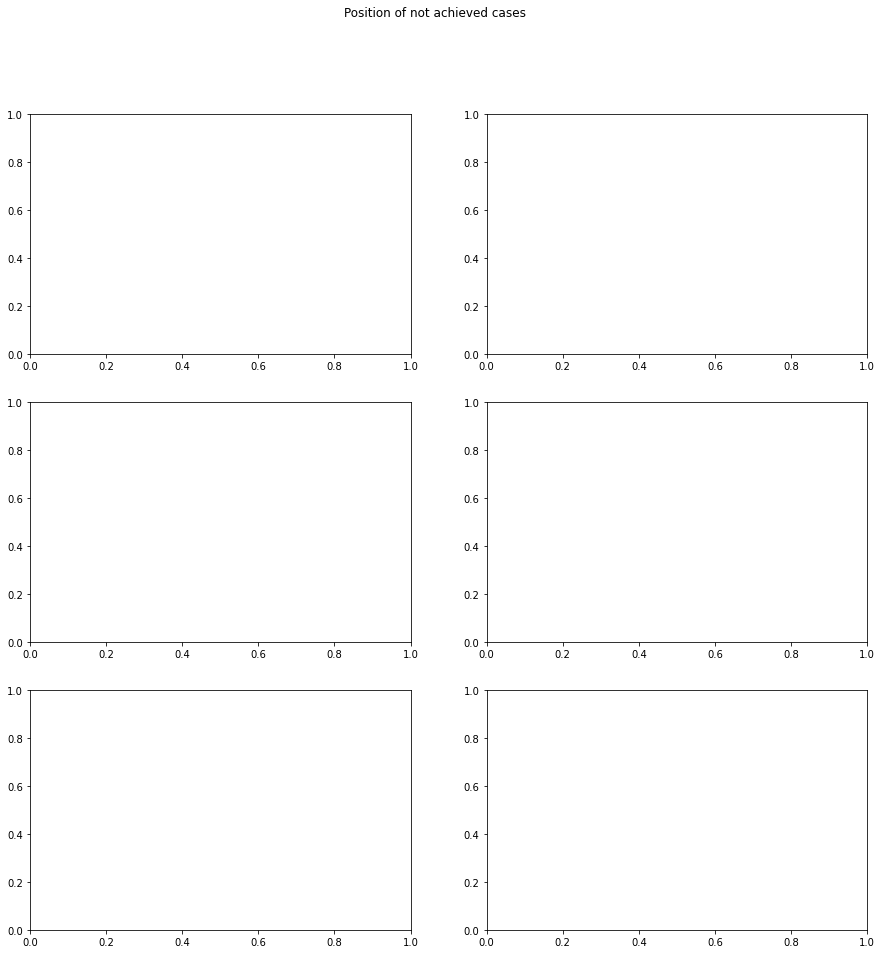

In [53]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

if cnt[3]:
    df = pd.DataFrame.from_dict(cnt[3], orient='index', columns=['count'])
    df['percentage'] = df/df.sum()
    df.sort_index().plot.bar(y='count', ax=axs[0, 0], rot=0)
    df.sort_index().plot.bar(y='percentage', ax=axs[0, 1], rot=0)

if cnt[5]:
    df = pd.DataFrame.from_dict(cnt[5], orient='index', columns=['count'])
    df['percentage'] = df/df.sum()
    df.sort_index().plot.bar(y='count', ax=axs[1, 0], rot=0)
    df.sort_index().plot.bar(y='percentage', ax=axs[1, 1], rot=0)

if cnt[7]:
    df = pd.DataFrame.from_dict(cnt[7], orient='index', columns=['count'])
    df['percentage'] = df/df.sum()
    df.sort_index().plot.bar(y='count', ax=axs[2, 0], rot=0)
    df.sort_index().plot.bar(y='percentage', ax=axs[2, 1], rot=0)

plt.suptitle('Position of not achieved cases')

In [165]:
dcts = [random_cfs, most_sim_cfs]
strategies = ['R', 'MSim']

dfs = [
    pd.DataFrame([[
        k, i.solution_found, i.iter_no['initial'], i.iter_no['best'], i.loss['initial'], i.loss['best'], i.cfs_dist, i.pos, s]
        for k, v in dct.items() for items in v for i in items if i is not None
    ]) for dct, s in zip(dcts, strategies)
]

cols = {'columns': {
    '0_x': f'init_target_pos_{strategies[0]}', '1_x': f'is_solved_{strategies[0]}',
    '2_x': f'init_iter_{strategies[0]}', '3_x': f'best_iter_{strategies[0]}',
    '4_x': f'init_loss_{strategies[0]}', '5_x': f'best_loss_{strategies[0]}',
    '6_x': f'iitems_del_{strategies[0]}', '7_x': f'f_target_pos_{strategies[0]}', '8_x': 'strategy',
    '0_y': f'init_target_pos_{strategies[1]}', '1_y': f'is_solved_{strategies[1]}',
    '2_y': f'init_iter_{strategies[1]}', '3_y': f'best_iter_{strategies[1]}',
    '4_y': f'init_loss_{strategies[1]}', '5_y': f'best_loss_{strategies[1]}',
    '6_y': f'iitems_del_{strategies[1]}', '7_y': f'f_target_pos_{strategies[1]}', '8_y': 'strategy'
}}
df = pd.merge(dfs[0], dfs[1], left_index=True, right_index=True).reset_index().rename(**cols)

In [252]:
def plot_data(x, y, ax, title):
    # calculate the max values to annotate on the plot
    y_max = y.max()

    # find the index of the max value
    x_ind = np.where(y == y_max)

    # find the x based on the index of max
    x_max = x.iloc[x_ind]
    # ----------------------------------------------------------------------------------------------------
    # plot the data
    ax.plot(x, y, color = "black")
    ax.scatter(x_max, np.tile(y_max, len(x_max)), s = 300, color = "green", alpha = 0.3)

    # annotate the text of the Max value
#     ax.annotate(r'Max value',
#                  xy = (x_max, y_max),
#                  xytext = (-90, -50),
#                  textcoords = 'offset points',
#                  fontsize = 16,
#                  arrowprops = dict(arrowstyle = "->", connectionstyle = "arc3,rad=.2")
#                )
    # ----------------------------------------------------------------------------------------------------
    # prettify the plot
    # fill the area with a specific color
    ax.fill_between(x, 0, y, where = 0 > y, facecolor='red', interpolate = True, alpha = 0.3)
    ax.fill_between(x, 0, y, where = 0 <= y, facecolor='green', interpolate = True, alpha = 0.3)

    # change the ylim to make it more pleasant for the viewer
    ax.set_ylim(y.min() * 1.1, y.max() * 1.1)

    # change the values of the x axis
    # extract the first 3 letters of the month
    # xtickvals = [str(m)[:3].upper() + "-" + str(y) for y,m in zip(df.date_converted.dt.year, df.date_converted.dt.month_name())]

    # this way we can set the ticks to be every 6 months.
    ax.set_xticks(x[::50])

    # change the current ticks to be our string month value
    # basically pass from this: 1967-07-01
    # to this: JUL-1967
    # ax.set_xticklabels(xtickvals[::6], rotation=90, fontdict={'horizontalalignment': 'center', 'verticalalignment': 'center_baseline'})

    # add a grid
    ax.grid(alpha = 0.3)

    # set the title
    # ax.set_title("Monthly variation return %");
    ax.set_title(title);

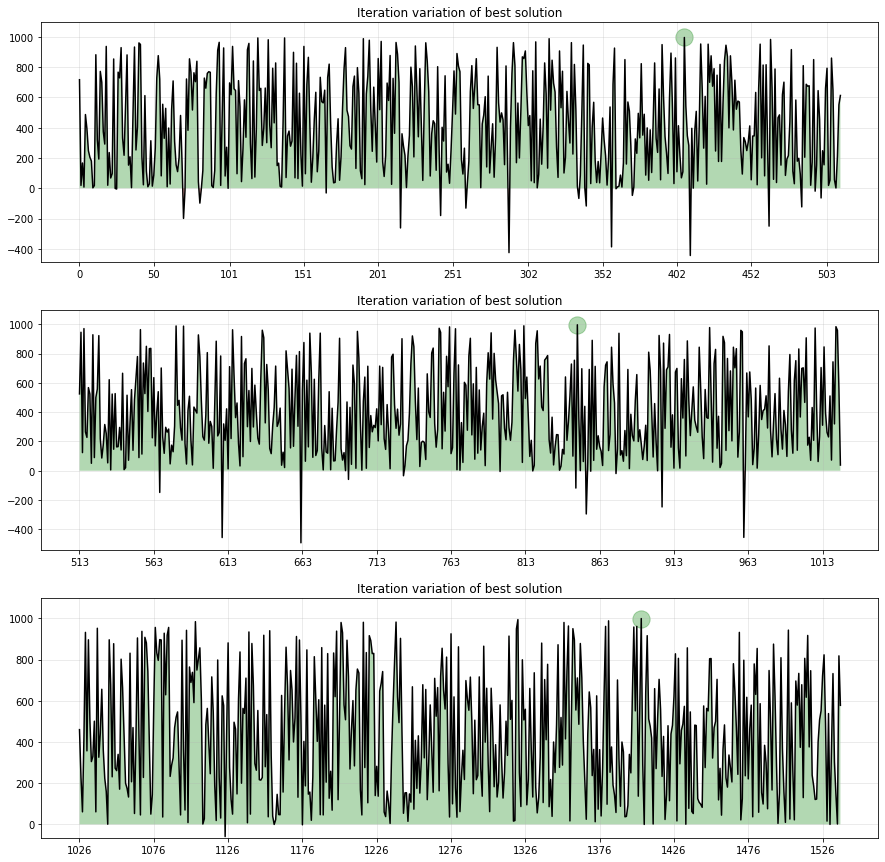

In [253]:
# instanciate the figure
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

# prepare the data for plotting
df["iter_diff"] = (df["best_iter_R"] - df["best_iter_MSim"])

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 3) & (df["is_solved_R"])]

# separate x and y 
x = tmp_df['index']
y = tmp_df["iter_diff"]

plot_data(x, y, ax[0], "Iteration variation of best solution")

# ----------------------------------------------------------------------------------------------------

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 5) & (df["is_solved_R"])]
# del tmp_df['index']
# tmp_df.reset_index(inplace=True, drop=True)
# tmp_df.reset_index(inplace=True)

# separate x and y 
x = tmp_df['index']
y = tmp_df["iter_diff"]

plot_data(x, y, ax[1], "Iteration variation of best solution")

# ----------------------------------------------------------------------------------------------------

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 7) & (df["is_solved_R"])]

# separate x and y 
x = tmp_df['index']
y = tmp_df["iter_diff"]

plot_data(x, y, ax[2], "Iteration variation of best solution")

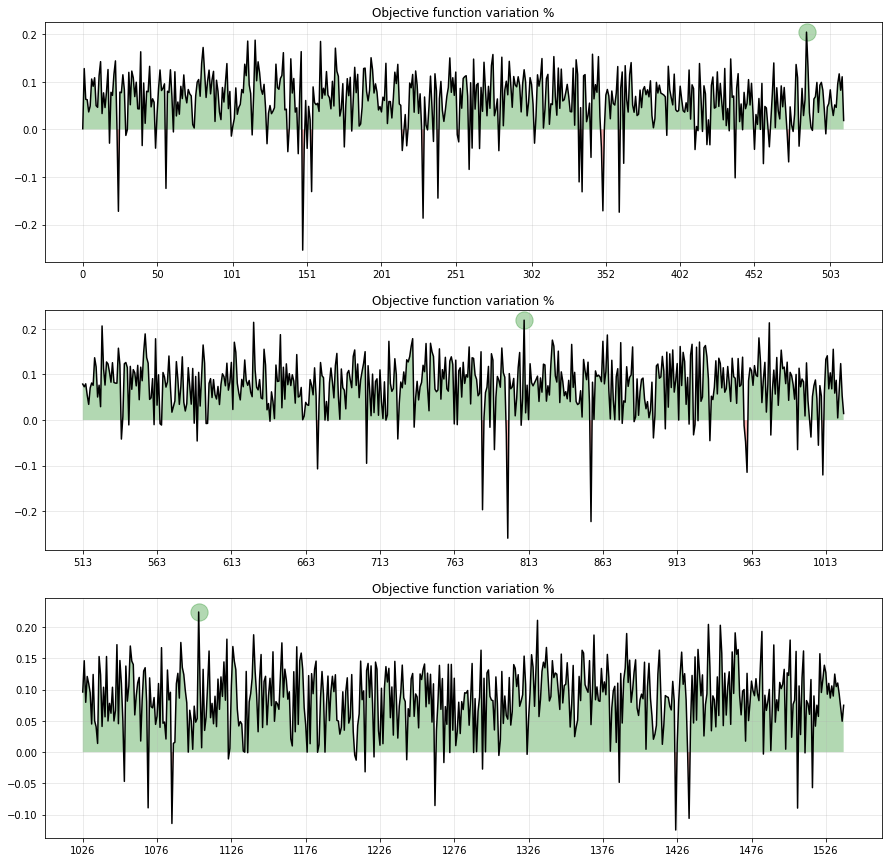

In [254]:
# # instanciate the figure
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

# prepare the data for plotting
df["loss_diff"] = (df["best_loss_R"] - df["best_loss_MSim"]) / df['best_loss_R']

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 3) & (df["is_solved_R"])]

# separate x and y 
x = tmp_df['index']
y = tmp_df["loss_diff"]

plot_data(x, y, ax[0], "Objective function variation %")

# ----------------------------------------------------------------------------------------------------

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 5) & (df["is_solved_R"])]

# separate x and y 
x = tmp_df['index']
y = tmp_df["loss_diff"]

plot_data(x, y, ax[1], "Objective function variation %")

# ----------------------------------------------------------------------------------------------------

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 7) & (df["is_solved_R"])]

# separate x and y 
x = tmp_df['index']
y = tmp_df["loss_diff"]

plot_data(x, y, ax[2], "Objective function variation %")

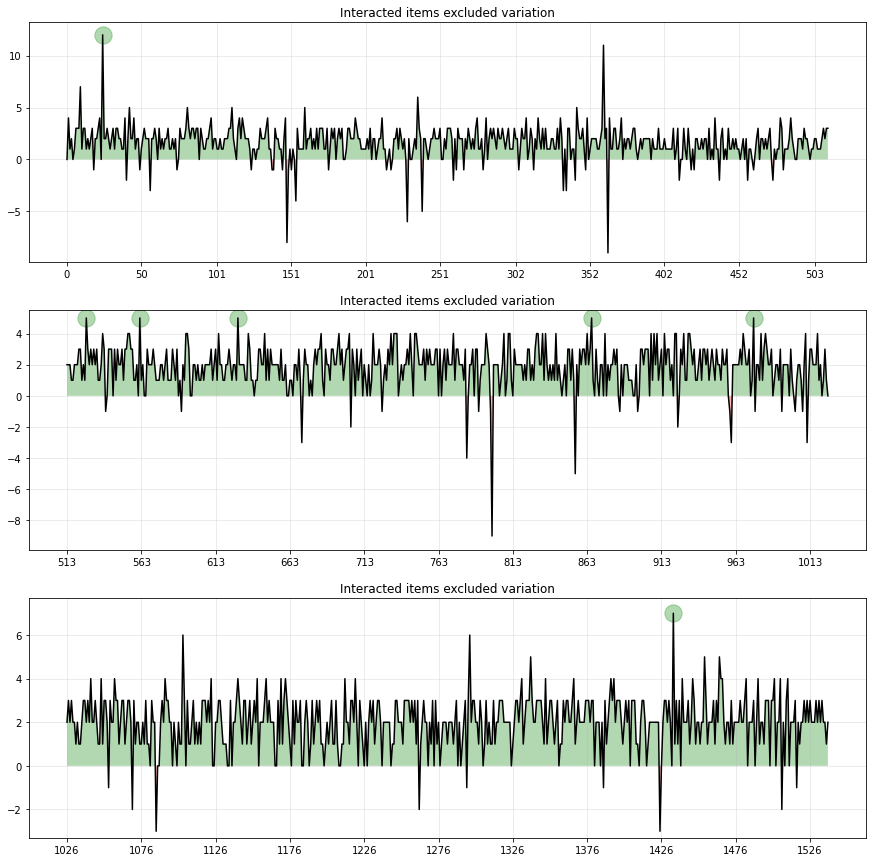

In [255]:
# instanciate the figure
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

# prepare the data for plotting
df["excluded_items_diff"] = (df["iitems_del_R"] - df["iitems_del_MSim"])

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 3) & (df["is_solved_R"])]

# separate x and y 
x = tmp_df['index']
y = tmp_df["excluded_items_diff"]

plot_data(x, y, ax[0], "Interacted items excluded variation")

# ----------------------------------------------------------------------------------------------------

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 5) & (df["is_solved_R"])]

# del tmp_df['index']
# tmp_df.reset_index(inplace=True, drop=True)
# tmp_df.reset_index(inplace=True)

# separate x and y 
x = tmp_df['index']
y = tmp_df["excluded_items_diff"]

plot_data(x, y, ax[1], "Interacted items excluded variation")

# ----------------------------------------------------------------------------------------------------

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 7) & (df["is_solved_R"])]
# del tmp_df['index']
# tmp_df.reset_index(inplace=True, drop=True)
# tmp_df.reset_index(inplace=True)

# separate x and y 
x = tmp_df['index']
y = tmp_df["excluded_items_diff"]

plot_data(x, y, ax[2], "Interacted items excluded variation")

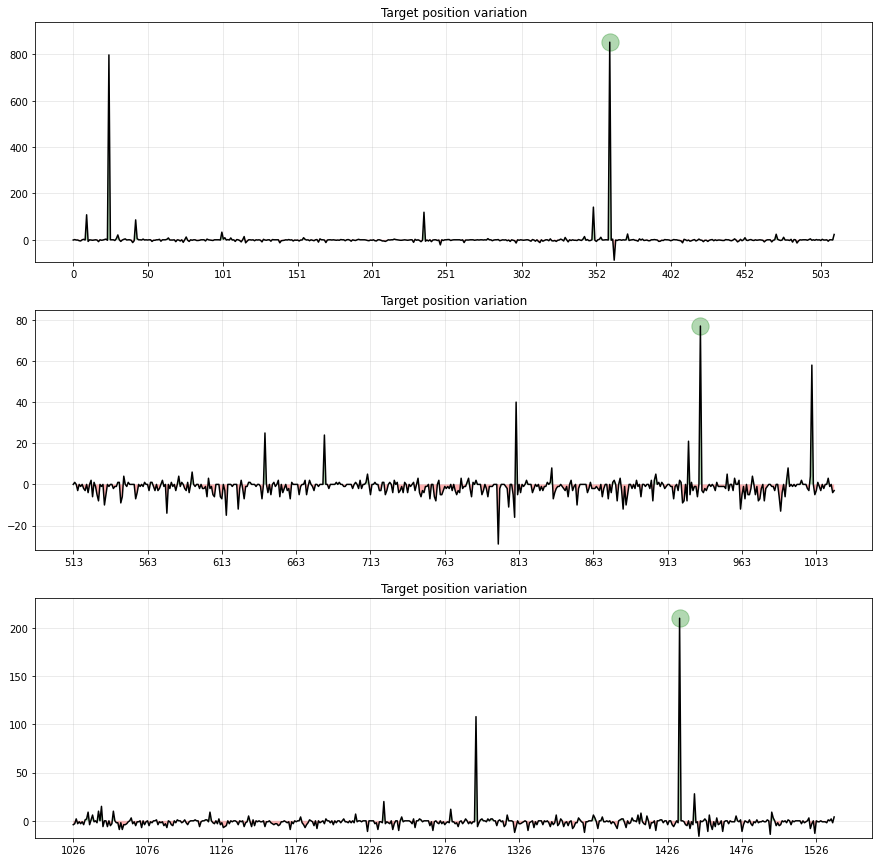

In [256]:
# instanciate the figure
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

# prepare the data for plotting
df["tpos_diff"] = (df["f_target_pos_R"] - df["f_target_pos_MSim"])

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 3) & (df["is_solved_R"])]

# separate x and y
x = tmp_df['index']
y = tmp_df["tpos_diff"]

plot_data(x, y, ax[0], "Target position variation")

# ----------------------------------------------------------------------------------------------------

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 5) & (df["is_solved_R"])]

# separate x and y 
x = tmp_df['index']
y = tmp_df["tpos_diff"]

plot_data(x, y, ax[1], "Target position variation")

# ----------------------------------------------------------------------------------------------------

# filter our df for a specific target_pos
tmp_df = df[(df["init_target_pos_R"] == 7) & (df["is_solved_R"])]

# separate x and y 
x = tmp_df['index']
y = tmp_df["tpos_diff"]

plot_data(x, y, ax[2], "Target position variation")